In [1]:
import sys
import os
import pandas as pd
import numpy as np
# sys.path.append('/root/barcode/')
sys.path.append('../')
from BarcodeScanner import tree_and_clustering, base_barcode
from itertools import product, combinations
from sklearn.linear_model import LinearRegression
import timeit


def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

def gen_full_X(num_var: int, sample_size :int):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    return raw_X

def gen_barcode_frame(num_var:int, sample_size:int):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    raw_colnames = raw_X.columns.tolist()
    raw_X['z'] = base_barcode.gen_barcode(raw_X).reshape(-1)
    raw_X = raw_X.drop(raw_colnames, axis = 1)
    return raw_X


In [2]:
from sys import getsizeof

## Experiment 1: Memory use of design matrix

In [56]:
number_of_variables = [3,4,5,6]
sample_sizes = range(5_000, 50_001, 5_000)
full_design_matrix_size = []
barcode_matrix_size = []
len(sample_sizes)

10

In [57]:
from tqdm import tqdm
for num_var, sample_size in tqdm(product(number_of_variables, sample_sizes), total = 10*4):
    x1 = gen_full_X(num_var, sample_size).to_numpy().astype(np.uint8)
    x2 = gen_barcode_frame(num_var, sample_size).to_numpy()
    full_design_matrix_size.append(x1.nbytes); barcode_matrix_size.append(x2.nbytes)

    

100%|██████████| 40/40 [06:42<00:00, 10.05s/it]


In [58]:
df_full_x = pd.DataFrame( product(number_of_variables, sample_sizes), columns = ['number of variables','number of observations'])
df_full_x['type'] = 'design matrix'
df_barcode = pd.DataFrame( product(number_of_variables, sample_sizes), columns = ['number of variables','number of observations'])
df_barcode['type'] = 'bar-code'
df_full_x['memory usage'] = full_design_matrix_size[-40:]; df_barcode['memory usage'] = barcode_matrix_size[-40:]

In [59]:
df = pd.concat([df_full_x,df_barcode]).reset_index(drop = True)

In [61]:
import seaborn as sns

In [62]:
import matplotlib.pyplot as plt

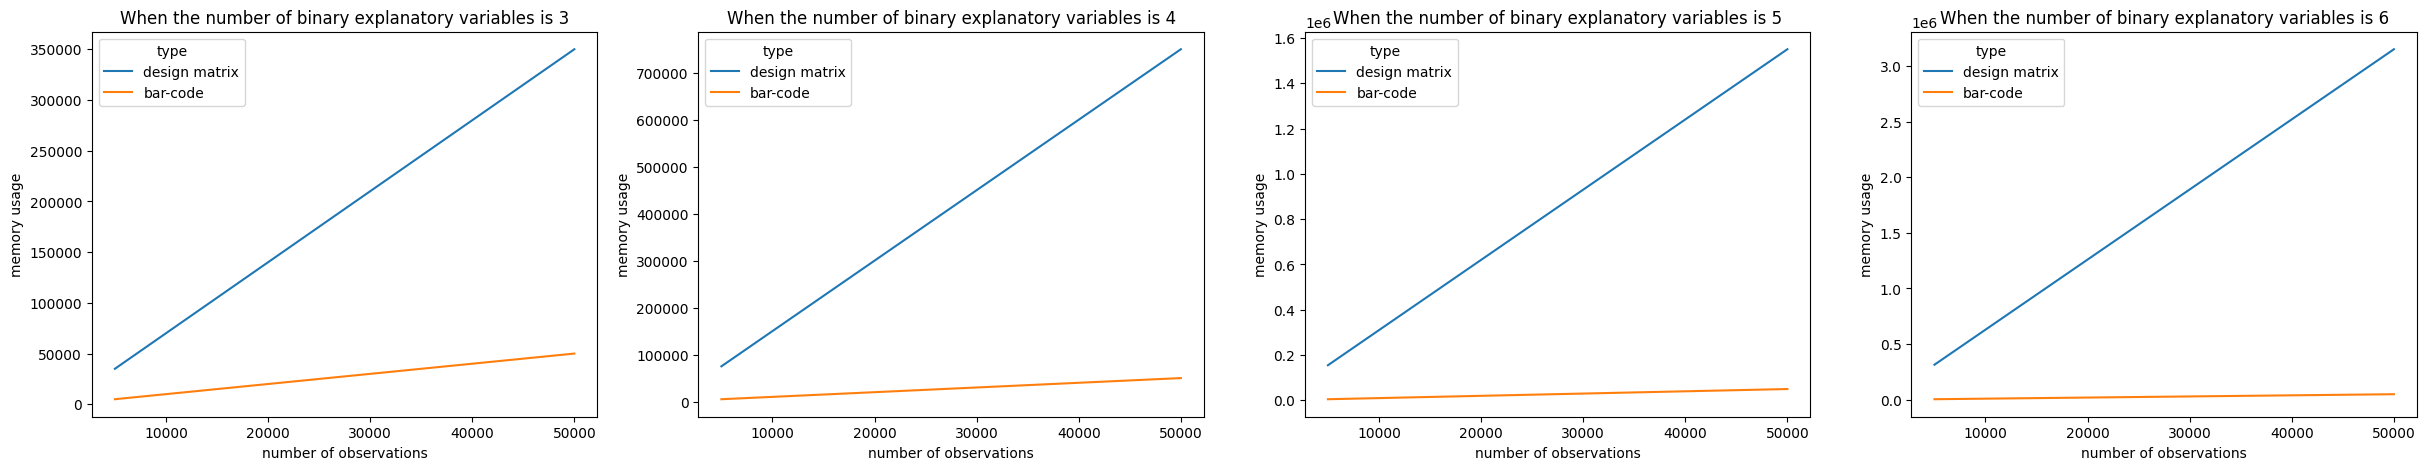

In [63]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
for k in range(4):
    sns.lineplot(data = df.loc[df['number of variables'].eq(k+3),:], x = 'number of observations', y = 'memory usage', hue = 'type', ax = ax[k])
    ax[k].set_title(f"When the number of binary explanatory variables is {k+3}")

fig.savefig('memory_simulation_result.png')

# Speed Testing

In [51]:
def gen_full_X(X):
    raw_X = X.copy()
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    return raw_X

def gen_barcode_frame(X):
    raw_X = X.copy()
    raw_colnames = raw_X.columns.tolist()
    raw_X['z'] = base_barcode.gen_barcode(raw_X).reshape(-1)
    raw_X = raw_X.drop(raw_colnames, axis = 1)
    return raw_X


In [23]:
X = gen_X(3, 50_000)
y = np.random.normal(size = 50_000)


In [24]:
df = gen_full_X(X)

In [29]:
timeit.repeat("gen_barcode_frame(X)", globals = globals(), number = 1, repeat = 4)

[0.17912954400026138,
 0.16711929600023723,
 0.165459920000103,
 0.16757048500039673]

#### Timing datasetups

In [46]:
number_of_variables = [3,4,5,6]
sample_sizes = range(5_000, 50_001, 5_000)
barcode_data_setup_times = []
full_model_data_setup_times = []


In [47]:
from tqdm import tqdm

In [39]:
for num_var, n in tqdm(product(number_of_variables, sample_sizes), total = 40):
    X = gen_X(num_var, n)
    barcode_data_setup_times.append(timeit.repeat("gen_barcode_frame(X)", globals = globals(), number = 1, repeat = 100))
    full_model_data_setup_times.append(timeit.repeat("gen_full_X(X)", globals = globals(), number = 1, repeat = 100))

100%|██████████| 40/40 [10:45:27<00:00, 968.19s/it]  


In [48]:
model_fit_barcode_times = []
model_fit_full_model_times = []

In [49]:
reg = LinearRegression()

In [53]:
gen_barcode_frame(X)

,z
0,0
1,3
2,4
3,4
4,3
...,...
4995,7
4996,6
4997,7
4998,4


In [54]:
from tqdm import tqdm
for num_var, n in tqdm(product(number_of_variables, sample_sizes), total = 40):
    X = gen_X(num_var, n)
    y = np.random.random(size = n)
    X_gen = gen_barcode_frame(X)
    df = pd.DataFrame(zip(X_gen.z, y), columns = ['x','y'])
    model_fit_barcode_times.append(timeit.repeat("df.groupby('x').mean()", globals = globals(), number = 1, repeat = 100))
    X_gen = gen_full_X(X)
    reg = LinearRegression()
    model_fit_full_model_times.append(timeit.repeat("reg.fit(X_gen, y)", globals = globals(), number = 1, repeat = 100))


100%|██████████| 40/40 [08:46<00:00, 13.17s/it]


In [47]:
df = pd.DataFrame(product(number_of_variables, sample_sizes), columns = ['number of variables','sample size'])

In [52]:
df['barcode_data_time_mean'] = [np.mean(x) for x in barcode_data_setup_times]
df['linear_data_time_mean'] = [np.mean(x) for x in full_model_data_setup_times]
df['barcode_model_fit_time_mean'] = [np.mean(x) for x in model_fit_barcode_times]
df['linear_model_fit_time_mean'] = [np.mean(x) for x in model_fit_full_model_times]

df.head()



,number of variables,sample size,barcode_data_time_mean,linear_data_time_mean,barcode_model_fit_time_mean,linear_model_fit_time_mean
0,3,5000,0.017460,0.287489,0.000968,0.001400
1,3,10000,0.034196,0.576951,0.000963,0.001882
2,3,15000,0.051454,0.859148,0.001108,0.002334
3,3,20000,0.067730,1.144353,0.001171,0.002760
4,3,25000,0.084394,1.452326,0.001255,0.003236


In [61]:
df.to_csv('chapter_1_simulation_result.csv', index = False)

In [72]:
df = pd.read_csv('chapter_1_simulation_result.csv')

In [73]:
df

,number of variables,sample size,methods,mean run-time
0,3,5000,barcode_data_time_mean,0.017460
1,3,5000,linear_data_time_mean,0.287489
2,3,5000,barcode_model_fit_time_mean,0.000451
3,3,5000,linear_model_fit_time_mean,0.001418
4,3,10000,barcode_data_time_mean,0.034196
...,...,...,...,...
155,6,45000,linear_model_fit_time_mean,0.197858
156,6,50000,barcode_data_time_mean,0.169098
157,6,50000,linear_data_time_mean,40.383592
158,6,50000,barcode_model_fit_time_mean,0.000904


In [66]:

import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
df.methods.replace({"linear_data_time_mean":"creating all interactions"}, inplace = True)
df.methods.replace({"barcode_data_time_mean":"bar-code variable"}, inplace = True)
df.methods.replace({"barcode_model_fit_time_mean":"cell means model with bar-code"}, inplace = True)
df.methods.replace({"linear_model_fit_time_mean":"linear regression model with all interaction effects"}, inplace = True)

In [83]:
df

,number of variables,sample size,methods,mean run-time
0,3,5000,bar-code variable,0.017460
1,3,5000,creating all interactions,0.287489
2,3,5000,cell means model with bar-code,0.000451
3,3,5000,linear regression model with all interaction e...,0.001418
4,3,10000,bar-code variable,0.034196
...,...,...,...,...
155,6,45000,linear regression model with all interaction e...,0.197858
156,6,50000,bar-code variable,0.169098
157,6,50000,creating all interactions,40.383592
158,6,50000,cell means model with bar-code,0.000904


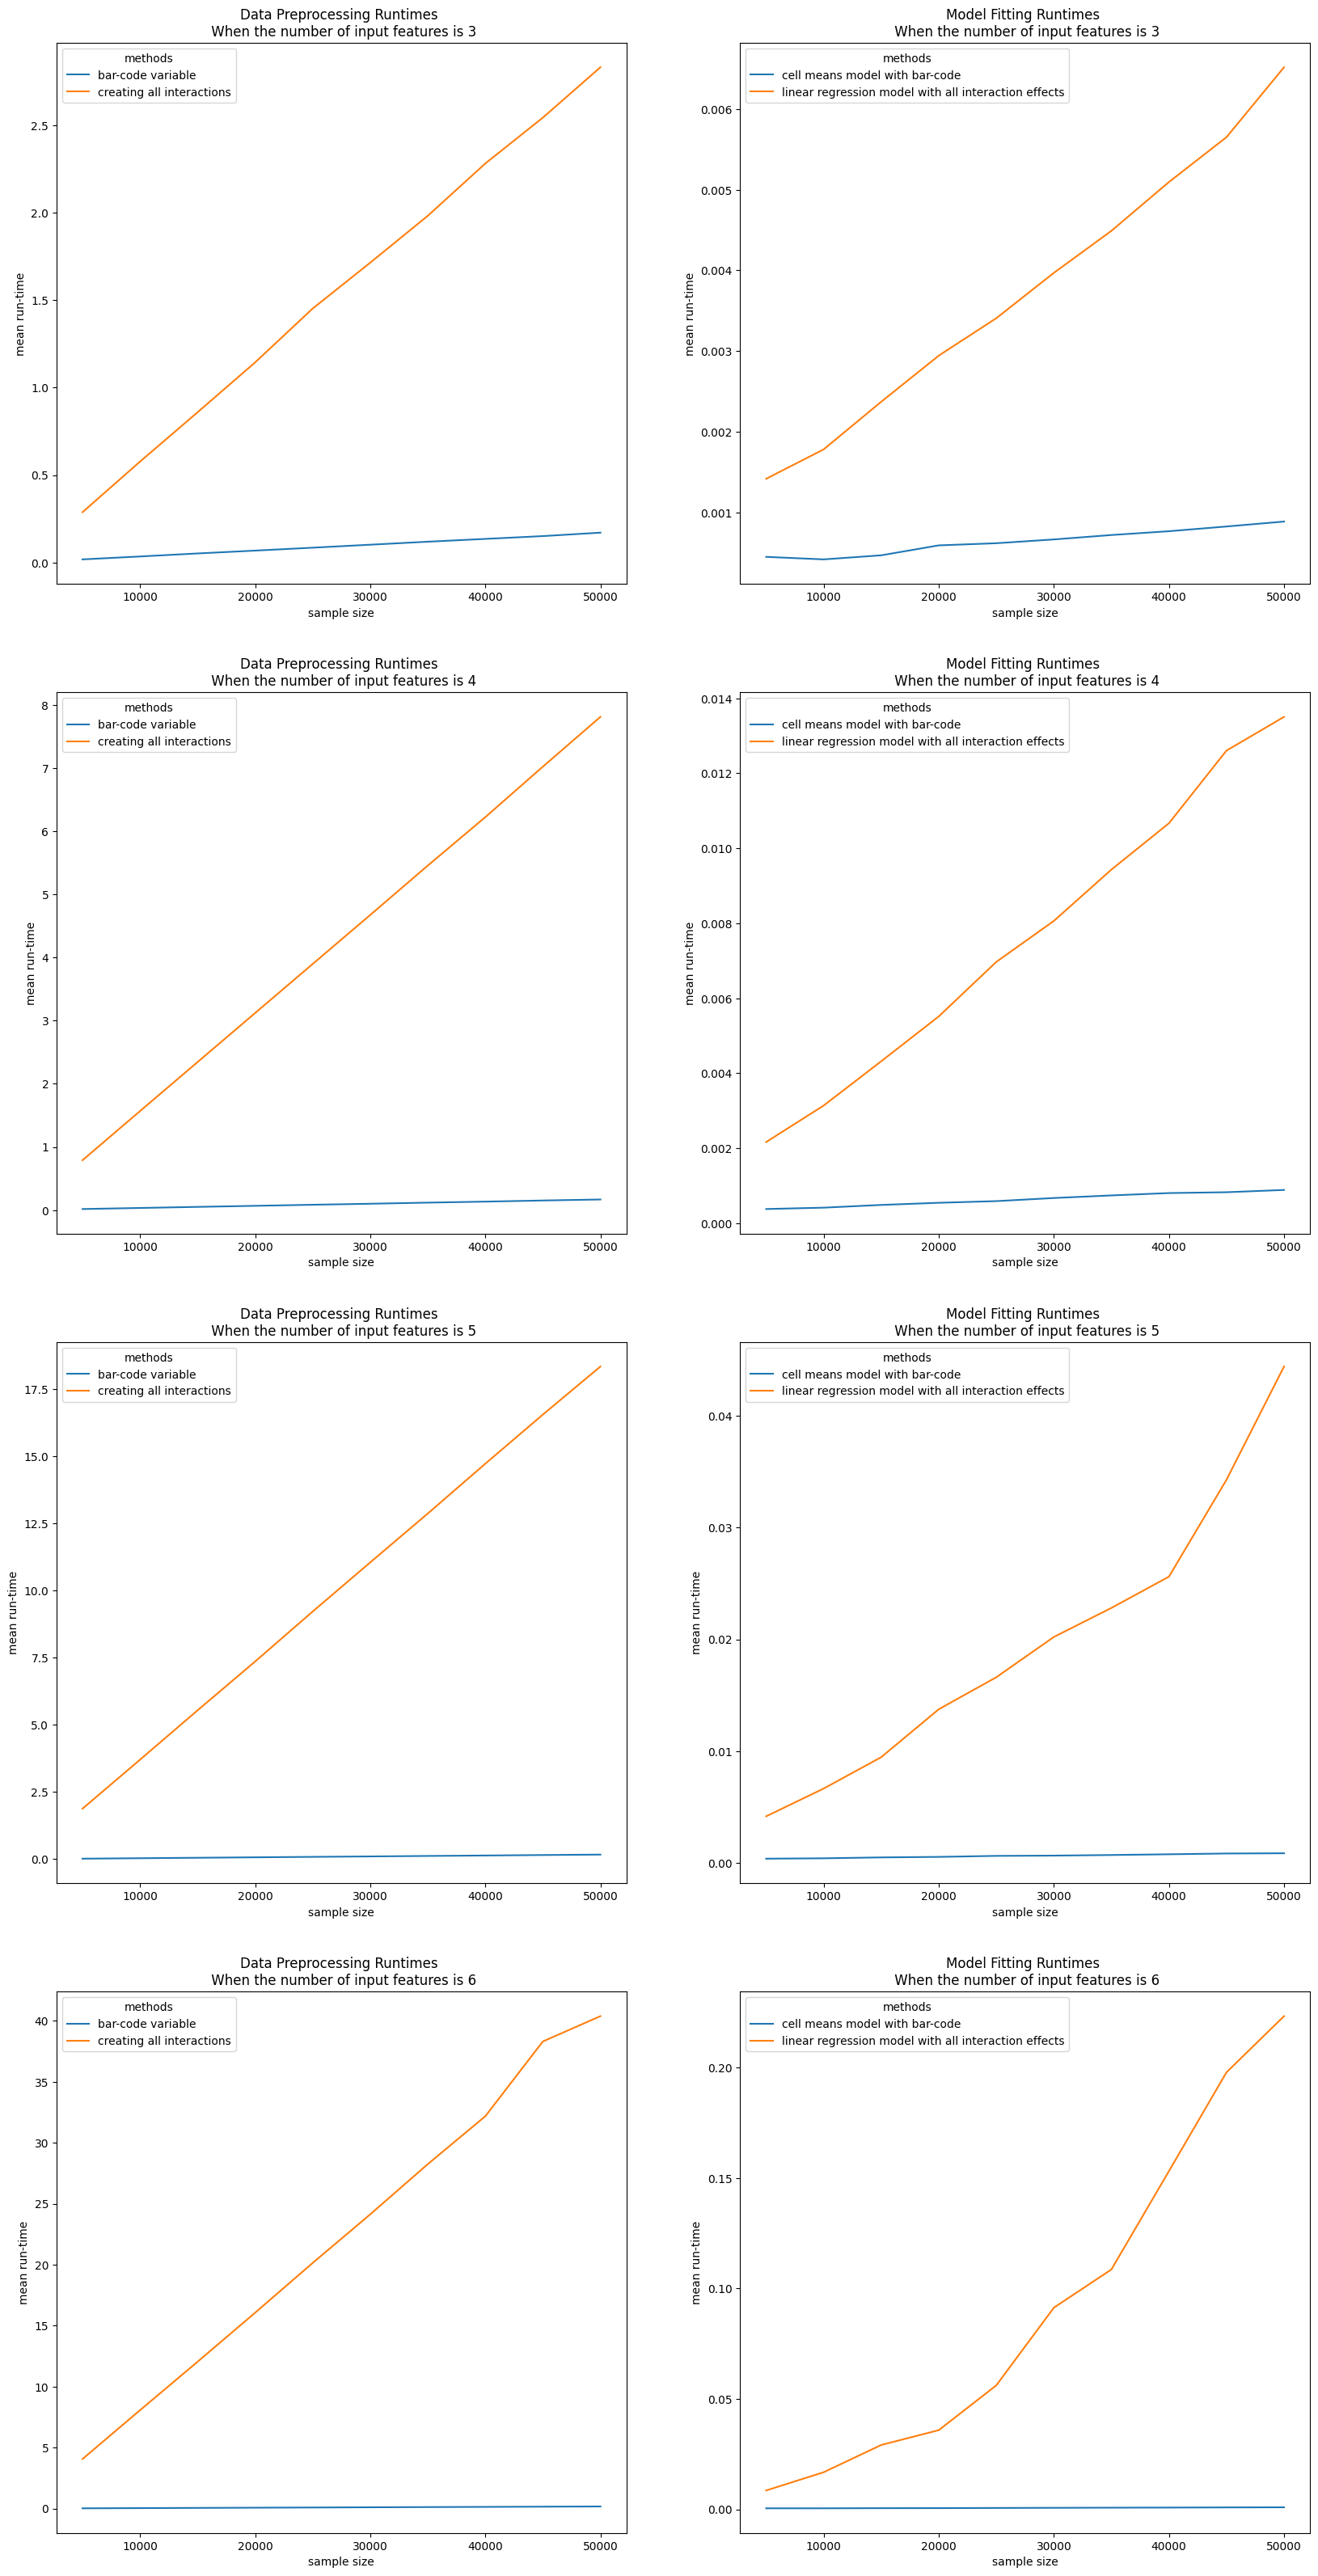

In [84]:
fig, ax = plt.subplots(4, 2, figsize = (20, 40))
for k in range(3, 7):
    sub_df = df.loc[df['number of variables'].eq(k),:]
    sub_df_data_time = sub_df.loc[sub_df['methods'].isin(['creating all interactions','bar-code variable']),:]
    sub_df_model_fit_time = sub_df.loc[sub_df['methods'].isin(['cell means model with bar-code',
                                                               'linear regression model with all interaction effects']),:]
    sns.lineplot(sub_df_data_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[k-3, 0])
    sns.lineplot(sub_df_model_fit_time, x = 'sample size', y = 'mean run-time', hue = 'methods', ax = ax[k-3, 1])
    ax[k-3, 0].set_title(f"Data Preprocessing Runtimes \n When the number of input features is {k}")
    ax[k-3, 1].set_title(f"Model Fitting Runtimes \n When the number of input features is {k}")